In [1]:
# Importing libraries and preprocessing scripts
import os
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler


import optuna
import xgboost as xgb
from xgboost import plot_importance

import importlib
import sys
sys.path.append('../src/')
import preproc_functions as ppf
importlib.reload(ppf)

<module 'preproc_functions' from '/home/jemima/Data/NigerDelta_MangroveClassification_Clean/scripts/../src/preproc_functions.py'>

# Model Training 

In [2]:
df = pd.read_csv("./NigerDelta_MangroveClassification_Clean/training_data/training_cleaned_scaled_fsel.csv")
var_colums = [c for c in df.columns if c not in  ['class']]

X = df.loc[:,var_colums]
y = df.loc[:,'class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8) #Train is 70%, Test is 30%
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.33, random_state=8) #Train 70%, Test 20%, Val 10%

X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((106444, 35), (30564, 35), (15055, 35), (106444,), (30564,), (15055,))

In [3]:
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3)

params={
 "learning_rate"    : [0.05, 0.10, 0.15],
 "max_depth"        : [6, 7, 8],
 "min_child_weight" : [4, 5, 6],
 "colsample_bytree" : [0.3, 0.5, 0.75],
 'subsample'        : [0.3, 0.5, 0.75],
 "n_estimators"     : [250, 500, 1000]
}


random_search = RandomizedSearchCV(
    estimator=model, 
    param_distributions=params, 
    n_iter=25,  # Number of parameter settings to sample
    cv=5, 
    verbose=True, 
    scoring="accuracy", 
    n_jobs=-1, 
    random_state=42
)
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters: {'subsample': 0.75, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.5}


In [6]:
def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    model = xgb.XGBClassifier(**params, use_label_encoder=False)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

[I 2025-01-28 16:17:22,258] A new study created in memory with name: no-name-4ce7f6b0-bf94-49e1-bc42-a14c49a8acc2
[I 2025-01-28 16:19:00,536] Trial 0 finished with value: 0.9065142133466516 and parameters: {'learning_rate': 0.01670570495467403, 'max_depth': 9, 'min_child_weight': 2, 'colsample_bytree': 0.9346791755370738, 'subsample': 0.8425327802357101, 'n_estimators': 804}. Best is trial 0 with value: 0.9065142133466516.
[I 2025-01-28 16:19:48,321] Trial 1 finished with value: 0.9019390515228156 and parameters: {'learning_rate': 0.1333723120215604, 'max_depth': 8, 'min_child_weight': 5, 'colsample_bytree': 0.516955064122308, 'subsample': 0.33375410345611783, 'n_estimators': 536}. Best is trial 0 with value: 0.9065142133466516.
[I 2025-01-28 16:20:03,399] Trial 2 finished with value: 0.9033388398618472 and parameters: {'learning_rate': 0.0660287409523368, 'max_depth': 6, 'min_child_weight': 3, 'colsample_bytree': 0.3182472765898472, 'subsample': 0.571272393169732, 'n_estimators': 192}

Best hyperparameters: {'learning_rate': 0.019799527436973316, 'max_depth': 7, 'min_child_weight': 4, 'colsample_bytree': 0.954407308844186, 'subsample': 0.6173192105253485, 'n_estimators': 816}


In [8]:
model_params = {'objective':'multi:softprob',
                'num_class':3,
                'learning_rate': 0.019799527436973316,
                'max_depth': 7,
                'min_child_weight': 4,
                'colsample_bytree': 0.954407308844186,
                'subsample': 0.6173192105253485,
                'n_estimators': 816,
                'reg_lambda':1,
                'reg_alpha':1
                }

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3)

evalset = [(X_train, y_train), (X_test, y_test)]

fit_params = {'early_stopping_rounds':42, 
              'eval_metric':['mlogloss','auc','merror'], 
              'eval_set':evalset}

model = xgb.XGBClassifier(**model_params)
model.fit(X_train, y_train, **fit_params)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

[0]	validation_0-mlogloss:1.07669	validation_0-auc:0.96734	validation_0-merror:0.10845	validation_1-mlogloss:1.07678	validation_1-auc:0.96531	validation_1-merror:0.11160
[1]	validation_0-mlogloss:1.05543	validation_0-auc:0.96930	validation_0-merror:0.10648	validation_1-mlogloss:1.05562	validation_1-auc:0.96712	validation_1-merror:0.10934
[2]	validation_0-mlogloss:1.03495	validation_0-auc:0.97014	validation_0-merror:0.10519	validation_1-mlogloss:1.03526	validation_1-auc:0.96805	validation_1-merror:0.10846
[3]	validation_0-mlogloss:1.01522	validation_0-auc:0.97065	validation_0-merror:0.10487	validation_1-mlogloss:1.01568	validation_1-auc:0.96854	validation_1-merror:0.10872
[4]	validation_0-mlogloss:0.99605	validation_0-auc:0.97088	validation_0-merror:0.10405	validation_1-mlogloss:0.99664	validation_1-auc:0.96874	validation_1-merror:0.10748


/home/jemima/mambaforge/envs/jofenv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/jemima/mambaforge/envs/jofenv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mlogloss:0.97753	validation_0-auc:0.97108	validation_0-merror:0.10370	validation_1-mlogloss:0.97822	validation_1-auc:0.96903	validation_1-merror:0.10833
[6]	validation_0-mlogloss:0.95968	validation_0-auc:0.97133	validation_0-merror:0.10325	validation_1-mlogloss:0.96051	validation_1-auc:0.96926	validation_1-merror:0.10718
[7]	validation_0-mlogloss:0.94235	validation_0-auc:0.97165	validation_0-merror:0.10296	validation_1-mlogloss:0.94332	validation_1-auc:0.96952	validation_1-merror:0.10774
[8]	validation_0-mlogloss:0.92551	validation_0-auc:0.97176	validation_0-merror:0.10291	validation_1-mlogloss:0.92660	validation_1-auc:0.96960	validation_1-merror:0.10797
[9]	validation_0-mlogloss:0.90937	validation_0-auc:0.97185	validation_0-merror:0.10283	validation_1-mlogloss:0.91058	validation_1-auc:0.96966	validation_1-merror:0.10764
[10]	validation_0-mlogloss:0.89350	validation_0-auc:0.97196	validation_0-merror:0.10278	validation_1-mlogloss:0.89487	validation_1-auc:0.96967	validat

In [9]:
model.save_model('./NigerDelta_MangroveClassification_Clean/model_versions/final_model.json')

Accuracy: 0.9074728438686036
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8002
           1       0.92      0.88      0.90     11144
           2       0.86      0.92      0.89     11418

    accuracy                           0.91     30564
   macro avg       0.92      0.91      0.91     30564
weighted avg       0.91      0.91      0.91     30564



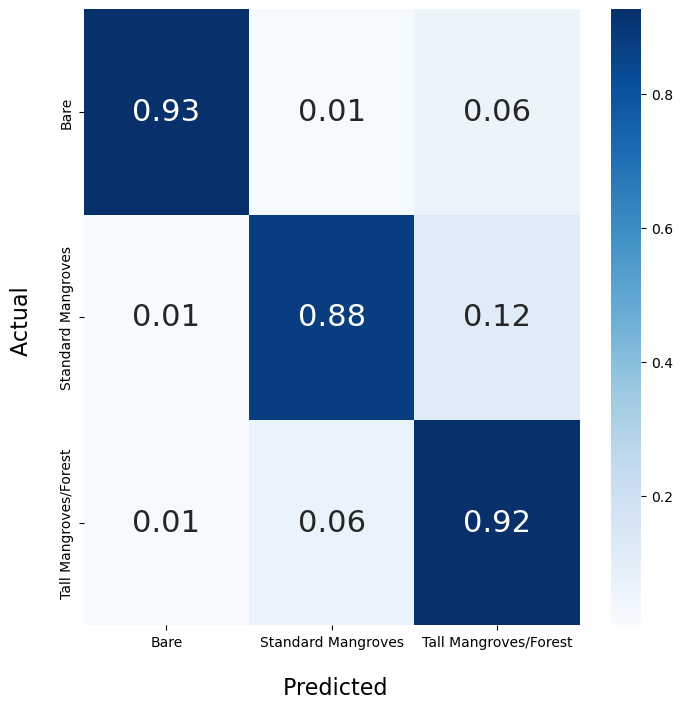

In [14]:
# Evaluate the model's performance on test set

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, predictions)
print(classification_rep)

y_pred = model.predict(X_test)
target_names = ['Bare','Standard Mangroves','Tall Mangroves/Forest']

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap=plt.cm.Blues, annot_kws={"fontsize":22})
plt.ylabel('Actual \n',fontsize=16,labelpad=0.2)
plt.xlabel('\n Predicted',fontsize=16,labelpad=0.2)
plt.show(block=False)

Accuracy: 0.9060777150448356
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3834
           1       0.92      0.87      0.90      5555
           2       0.85      0.92      0.89      5666

    accuracy                           0.91     15055
   macro avg       0.92      0.91      0.91     15055
weighted avg       0.91      0.91      0.91     15055



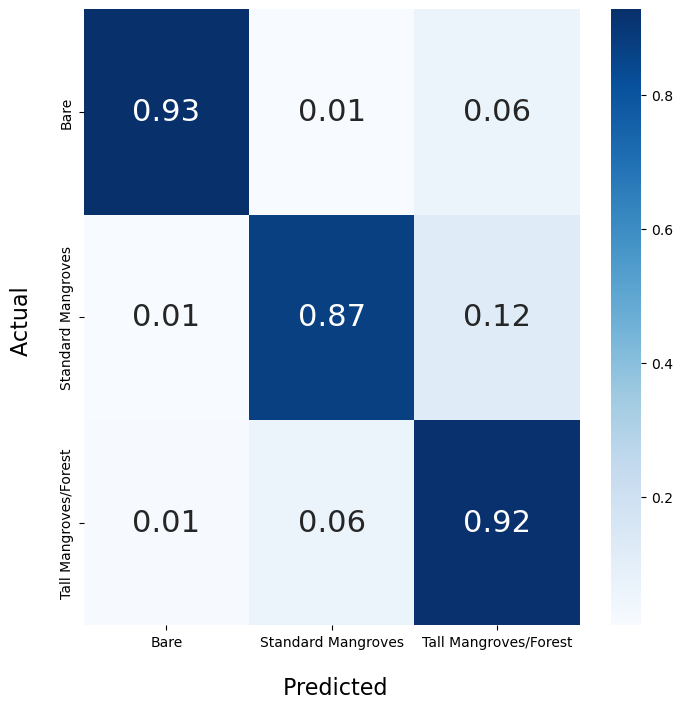

In [13]:
# Evaluate the model's performance on validation set

predictions = model.predict(X_valid)
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_valid, predictions)
print(classification_rep)

y_pred = model.predict(X_valid)
target_names = ['Bare','Standard Mangroves','Tall Mangroves/Forest']

cm = confusion_matrix(y_valid, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap=plt.cm.Blues, annot_kws={"fontsize":22})
plt.ylabel('Actual \n',fontsize=16,labelpad=0.2)
plt.xlabel('\n Predicted',fontsize=16,labelpad=0.2)
plt.show(block=False)

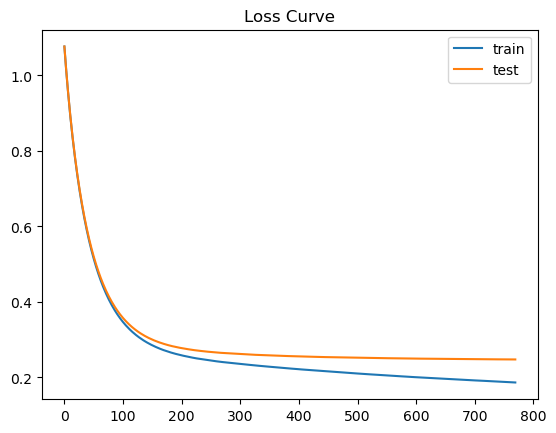

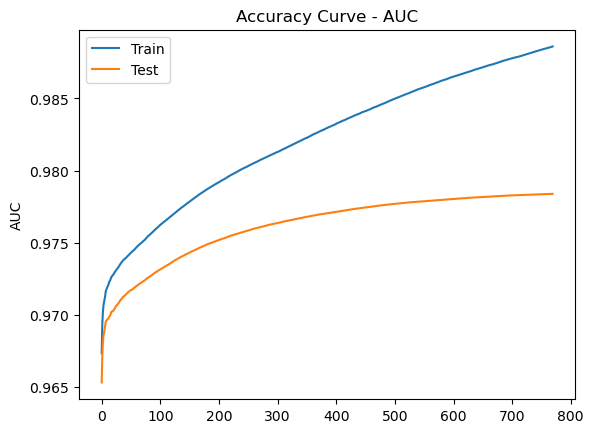

In [15]:
results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.title('Loss Curve')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(results['validation_0']['auc'], label='Train')
ax.plot(results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('Accuracy Curve - AUC')
plt.show()